# Cluster Analysis


Clustering analyses are a group of methods designed to group datapoints into groups or 'clusters' such that datapoints grouped together are more similar to eachother than those not grouped together. In the context of electrophysiology, we apply clustering analysis to our dataset of recorded neurons with the aim of grouping those neurons into classes of neurons with similar properties. In this specific application, we use the spiking statistics of DRN neurons recorded under anaesthesia to identify groups of neurons with similar baseline spiking patterns.

## The dataset


We use a dataset of 618 recorded DRN neurons. These neurons were recorded for at least 60 minutes in anaesthitised mice. For each neuron, two descriptive statistics were used to characterise its spiking pattern over the 60 minute period: the mean firing rate and the coeffisient of variation of the interspike interval. These two statistics were used as previous experiments [using juxtacellular labelling] indicate that these statistics are key indicators of neurochemical identity (neurotransmitter expression) for DRN neurons. 


##### The following code loads the data and excludes some recordings

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import scipy.cluster.hierarchy as sch
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
# matplotlib.rcParams['lines.linewidth'] = 5


def exclude_specified_recordings(df, recordings):
    return df[~df['recording_id'].isin(recordings)].copy()


save_dir = r'E:\figures\clustering'

# data already excluded chronic studies
path_to_data = r'E:\db\excluded_dataset.csv'
df_all = pd.read_csv(path_to_data)


recordings_to_exclude = [2, 4, 7, 17]
df = exclude_specified_recordings(df_all, recordings_to_exclude)
# df.to_csv(r'E:\db\recordings_excluded.csv', index=False)

### Feature Scaling


We are using two variables to separate out clusters of DRN neurons with similar spiking properties: Mean firing rate and CV-ISI. These variables are measured on different scales: i.e. mean firing rate vaires from ~ 0.5-60 [Hz] whereas CV ISI varies from ~ 0 - 1.6. If clustering was performed on the data in this format, then changes in mean firing rate would be weighted more strongly than changes in CV ISI. To prevent this from happening, we rescale the data by standardising it. This involves transforming the data to a Z-Scores. The transformed data is on the same scale across cv-ISI and mean firing rate.

Formula for stardisation of feature Xi (where x represents a vector all values of feature i):

\begin{align}
\ x_i & = (x_i - \mu_{x_i})/ \sigma_{x_i} \\
\end{align}


In [2]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X = df[['mfr', 'cv isi']]
X = scaler.fit_transform(X)

## Determening Clustering Tendency


Clustering analysis will return clusters for any input dataset regardless of wherether there truly exists subgroups within the data. The first step in any clustering analysis should thereforebe to perform an anlysis to assess the suitability of clustering methods for the data.

#### The Hopkins Statistic

The hopkins statistics is used to assess the clustering tendency of a dataset by measuring the probability that a given dataset is produced by a uniform distrobution

For a dataset **D**:

1. Sample uniformly *n* points from **D**
2. For each point *pi*, find its nearest neighbor, *pj*
3. Generate a simulated dataset ( R ) drawn from a random uniform distrobution with *n* points and the same variation as D.
4. For each point *qi* in **R**, find its nearest neighbour *qj* in D. Compute the distance between the points: *dist(qi, qj)*
5. Calculate the Hopkins statistic as the mean nearest neightbor distance in the random dataset divided by the sum og the mean nearest neightbor distances in the real dataset and across the simulatied dataset


A values of H about 0.5 indicates that the data are uniformly distrobuted. The Null hypothesis is that the dataset is uniformly distrobuted, the alternative hypothesis is that the dataset is 

**if the H value is close to 0 then we can reject the Null Hypothesis and conclude the dataset D is significantly clusterable data**

## Clustering Methods


These are many different clustering algorythms available. Each has advantages and disadvantages. We use three algorythms here and use the insights from each to estimate: *the **optimal number**  of clusters* and *the cluster **membership** of each neruon*

### K-Means clustering


The K-Means algorithm searches for a predetermined number of clusters within  a multi-featured dataset. 

##### Assumptions

K-Means makes two assumptions of the properties of a cluster.

1. The centre of a cluster or **centroid** is the mean across each member of the cluster of each attribute used to separate out the clusters

2. Each point in a cluster is closer to the centroid of the cluster it belongs to than the centroid of other clusters

##### Method: Expectation Maximisation

K-means is an itterative algorithm i.e. it is performed in multiple steps, with some steps repeated until the algorithm is finished. The 

1. Guess cluster centres
2. Repeat until converged [**Expectation Maximisation**]:
    1. Assign points to belong to the cluster whose centroid is closest [*Expetation*]
    2. Update cluster centroids to be the new mean of all points within that cluster [*Maximisation*]


##### Finding Optimal Numbers of Clusters 

A limitation of kmeans is that you need to tell it how many clusters to expect, it cannot learn this number from the data.

There are a number of aproaches to determining the optimal number of clusters. These include Siloette analysis and the Elbow method


###### Silhouette analysis
Silhouette analysis provides information about how well a given datapoint fits its asinged cluster and the relative advantage of the use of different numbers of clusters to fit the data. A silhouette coefficient ranges from 1 to -1 and is calculated for each datapoint. A score of 1 indicates a good separation in space from other clusters, a score of 0 indicates it is near the disicion boundry between its asigned cluster and another cluster and a score of -1 indicates a poor asignment.

To use silhouette scores to determine the optimal number of clusters: favor higher average silhouette scores and numbers of clusters that result in small deviations from individual clusters from the average silhouette score across clusters

In [3]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import numpy as np


def silhouette(n_clusters, X, y_pred, ax):
    
    ax.set_xlim([-0.35, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    

    silhouette_avg = silhouette_score(X, y_pred)
    sample_silhouette_values = silhouette_samples(X, y_pred)
    
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                         alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax.set_title(f"{n_clusters} Clusters.")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    return ax


def silhouett_analysis(model, X, n_iters):
    f, a = plt.subplots(nrows=int(n_iters//2) + n_iters % 2, ncols=2, 
                        figsize=(20, 30))
    
    for i, n in enumerate(range(2, n_iters+2)):
        if model == 'agg_hc':
            m = AgglomerativeClustering(n_clusters = n, 
                             affinity = 'euclidean',
                            linkage = 'ward')
        else:
            raise ValueError('unknown model')
        y_pred = m.fit_predict(X)
        a.flatten()[i] = silhouette(n_clusters=n, X=X, y_pred=y_pred, ax=a.flatten()[i])
    f.suptitle('Silhouette Analysis across Various Numbers of Clusters', fontsize=35)

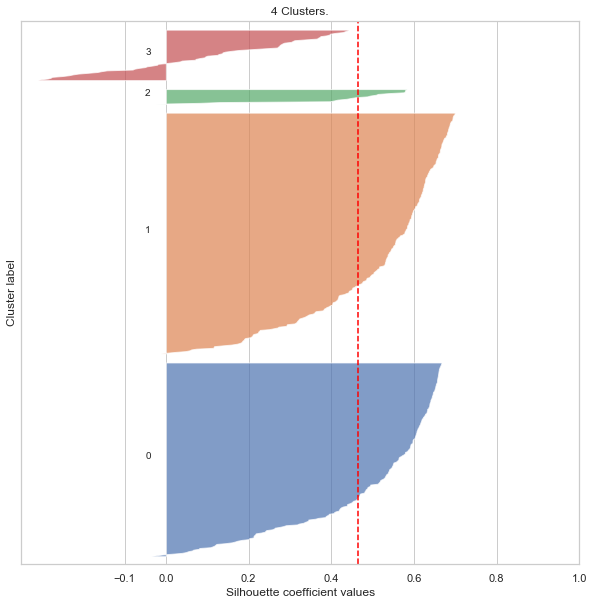

In [4]:
f, a = plt.subplots(figsize=(10, 10))
n_clusters=4
m = AgglomerativeClustering(n_clusters = n_clusters, 
                             affinity = 'euclidean',
                            linkage = 'ward')

y_pred = m.fit_predict(X)
silhouette(n_clusters, X, y_pred, ax=a)

# plt.savefig(os.path.join(save_dir, 'silhouette_1_run.png'), dpi=300)

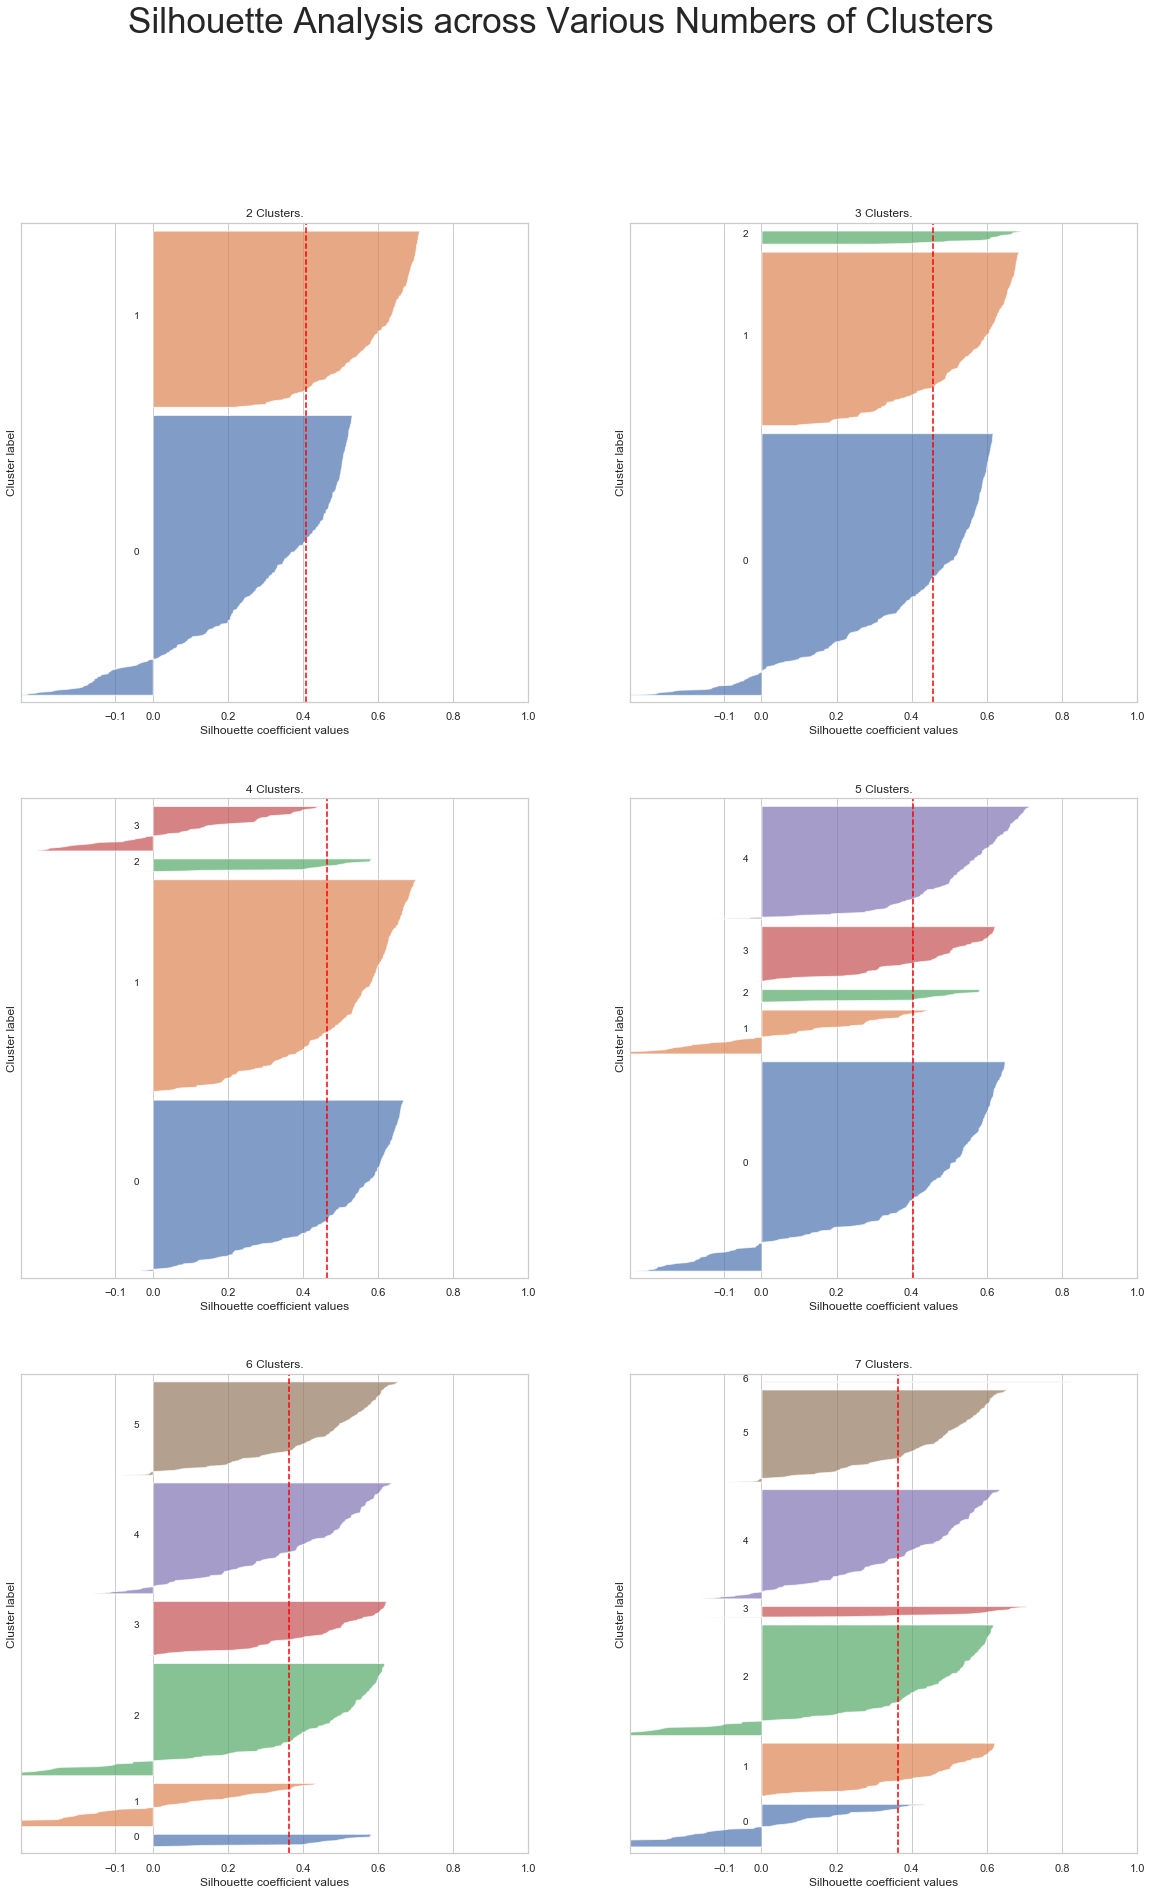

In [5]:
f = silhouett_analysis(model='agg_hc', X=X, n_iters=6)
# plt.savefig(os.path.join(save_dir, 'silhouette.png'), dpi=300)

#### The Dunn index

The dunn index is a metric of clustering validation. It is calculated as follows:
1. For each cluster, compute the distance between each of the objects in the cluster and the other clusters. Use the minimum of these ditances as the inter-cluster separation
2. For each cluster, compute the distance between the objects of the same cluster. Use the maximum of this intra-cluster distance as the intra-cluster compactness
3. Caclulate the Dunn index:


**D** =  (intercluster_separation) / (intracluster_distance)

If the dataset contains compact and well-defined clusters, then the diameters is expected to be small and the distance between clusters is expected to be large. Therefore the Dunn index should be large.

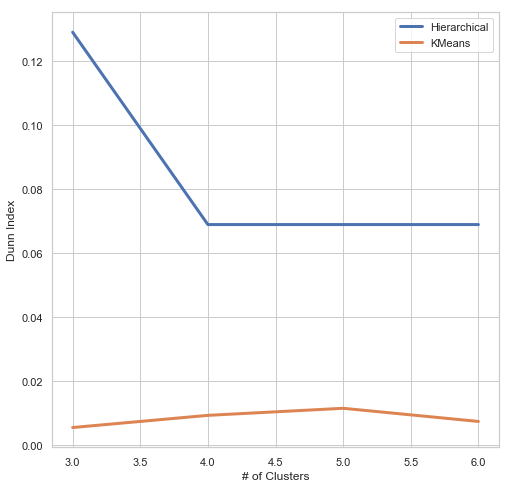

In [7]:
comp_tidy = os.path.join('E:\db', 'comp_tidy.csv')
comp_tidy = pd.read_csv(comp_tidy)

f, a = plt.subplots(nrows=1, figsize=(8, 8))

g = comp_tidy.groupby('Method')

for name, group in g:
    a.plot(group['Clusters'], group['Dunn'], label=name, linewidth=3)
    a.legend()
    a.set_ylabel('Dunn Index')
    
#     a[1].plot(group['Clusters'], group['Sillhouette'], label=name,  linewidth=3)
#     a[1].legend()
#     a[1].set_ylabel('Silhouette Score')
    a.set_xlabel('# of Clusters')

# plt.savefig(os.path.join(save_dir, 'Dunn.png'), dpi=300)

In [8]:
list(sns.color_palette(n_colors=4).as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52']

In [48]:
X.shape

(618, 2)

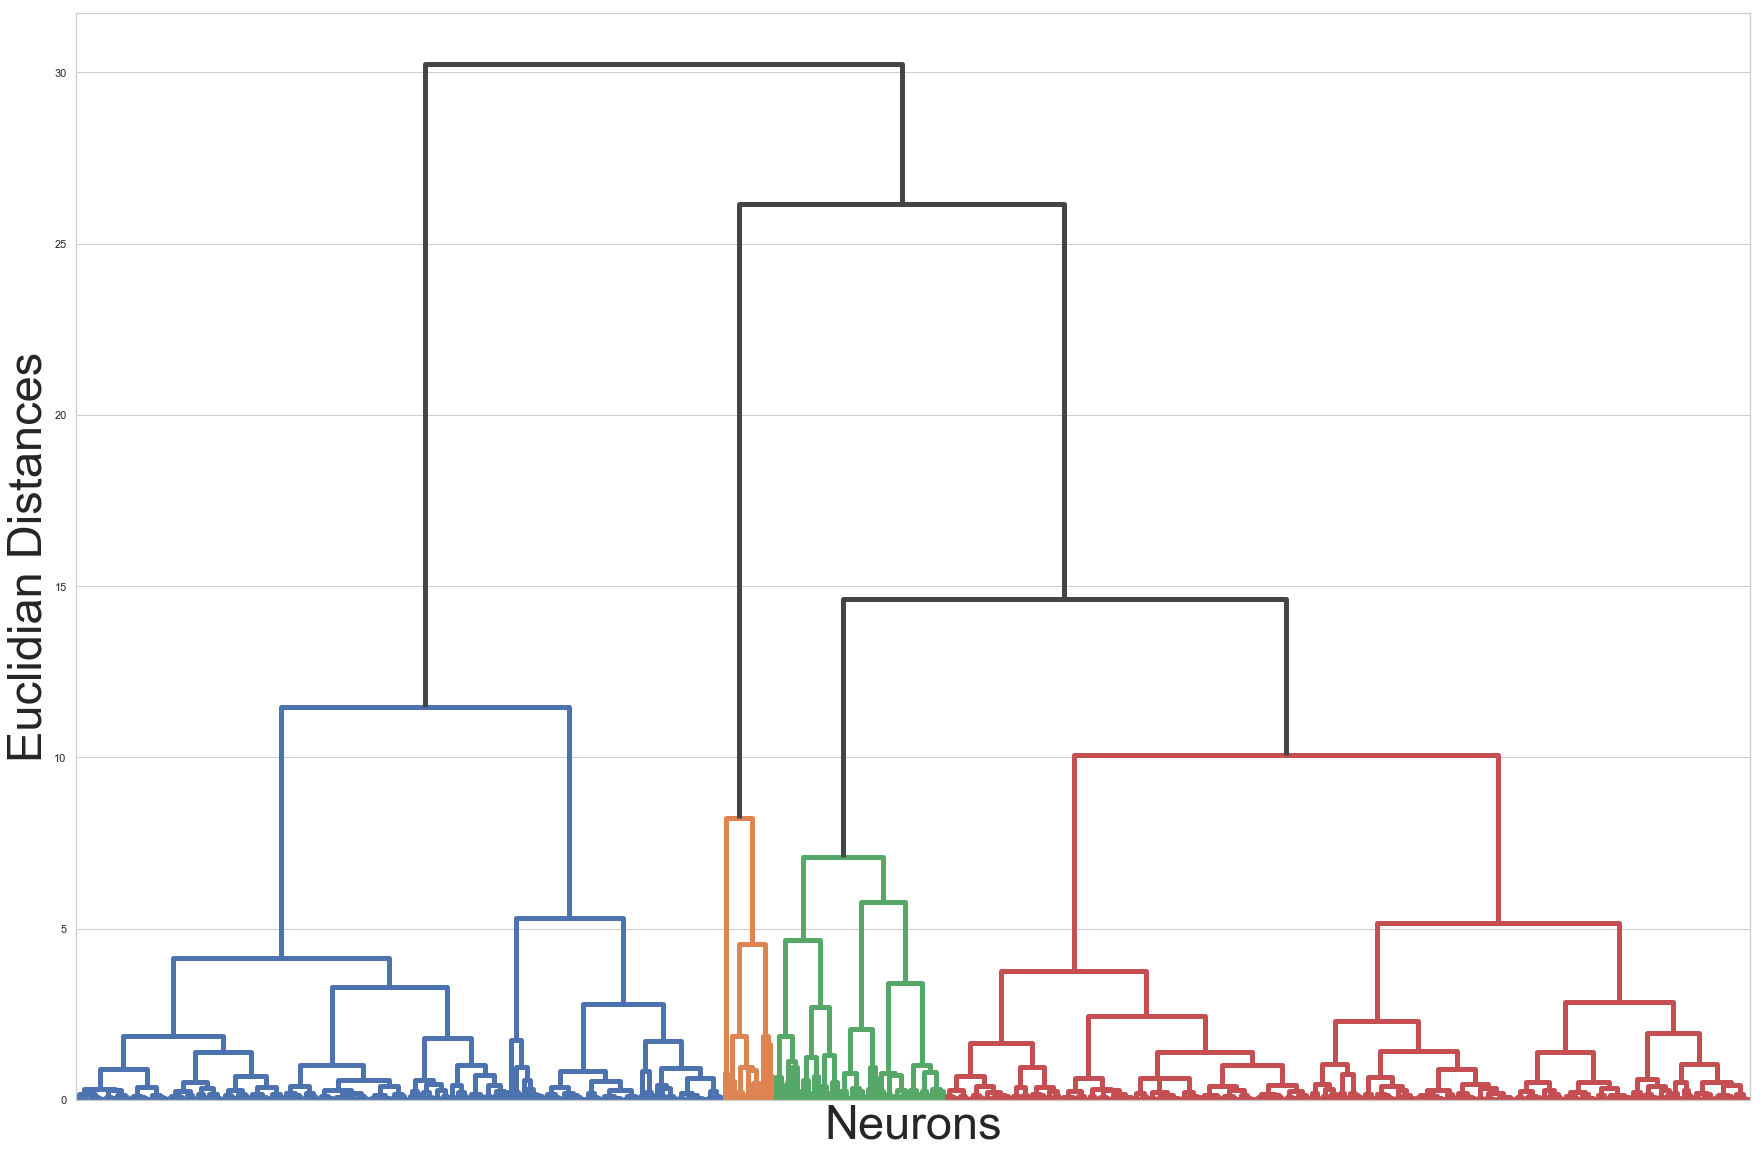

In [59]:
import seaborn as sns


f, a = plt.subplots(figsize=(30, 20))

cols = list(sns.color_palette(n_colors=4).as_hex())
sch.set_link_color_palette(cols)

with plt.rc_context({'lines.linewidth': 5}):
    
    dendrogram = sch.dendrogram(sch.linkage(X, method='ward'), 
                            color_threshold=12.5, no_labels=True,
                           above_threshold_color='#444547')
# plt.title('Dendrogram')
plt.xlabel('Neurons',  fontdict={'fontsize': 47})
plt.ylabel('Euclidian Distances', fontdict={'fontsize': 47})
plt.savefig(os.path.join(save_dir, 'dendrogram.png'), dpi=300)

In [10]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = 4, 
                             affinity = 'euclidean',
                            linkage = 'ward')

y_hc = hc.fit_predict(X)
df['hc_cluster'] = y_hc


In [11]:
d = {'0': 'Slow Irregular',
    '1': 'Clocklike Slow Regular',
    '2': 'Very Fast Regular',
    '3': 'Fast Varied'}

df['hc_cluster'] = df['hc_cluster'].astype(str).map(d)

In [12]:
d = {'Slow Irregular':cols[0],
    'Clocklike Slow Regular': cols[3],
    'Very Fast Regular': cols[1],
    'Fast Varied': cols[2]}

df['colors'] = df['hc_cluster'].astype(str).map(d)

In [56]:
def plot_clusters(df, ax):
    
    g = df.groupby('hc_cluster')

    for name, gr in g:
        ax.scatter(gr['cv isi'], gr['mfr'], 
                   c=gr['colors'].values[0], label=name, 
                   alpha=0.7, s=np.ones(len(gr))*85)
    
    ax.legend()
    ax.set_xlabel('Coefficient of Variation of ISI', fontdict={'fontsize':35})
    ax.set_ylabel('Mean Baseline Firing Rate [Hz]', fontdict={'fontsize':35})
    ax.legend(loc=0, prop={'size':39})
    return ax

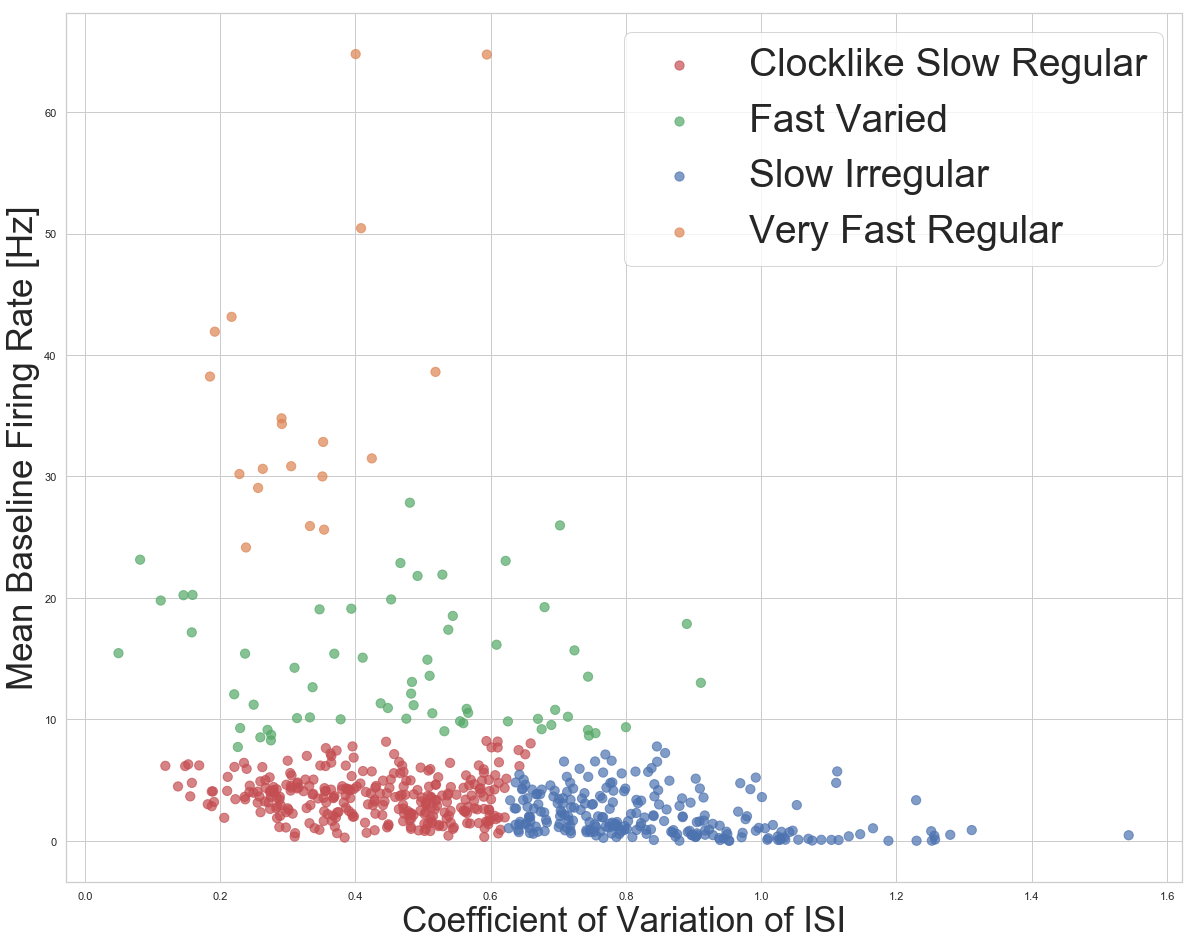

In [57]:
f, a = plt.subplots(figsize=(20, 16))

plot_clusters(df, a)
plt.savefig(os.path.join(save_dir, 'distrobutions.png'), dpi=300)

In [ ]:
df.drop('cluster', axis=1, inplace=True)
# df.to_csv( r'E:\db\CLUSTERS_DONE.csv', index=False)